In [3]:
import cv2
import numpy as np
import torch
import os

from PIL import Image
from uuid import uuid4

In [4]:
WHOLE_MODEL_PATH = './unet_resnet34_whole.pth'
IMAGE_SIZE = (480, 320)

In [5]:
model = torch.load(WHOLE_MODEL_PATH, map_location=torch.device('cpu'))

In [6]:
class Scaler(object):
    """Отмасштабировать изображения сохранив пропорции.
    
    Пустые места будут заполнены отражениями.

    Аргументы:
        image: Изображение в HWC формате.
        size: Требуемый размер, пара W, H.
    """
    def __init__(self, size, grayscale=False):
        self._size = size
        self._grayscale = grayscale
        self._padding = 0
    
    def set_padding(self, padding):
        self._padding = padding
        
    def __call__(self, image):
        if not isinstance(image, np.ndarray):
            image = np.array(image)
        grayscale = self._grayscale
        rw, rh = self._size
        p = self._padding
        h, w, c = image.shape
        scale_x = rw / w
        scale_y = rh / h
        scale = min(scale_x, scale_y)
        sw = int(scale * w)
        sh = int(scale * h)
        offset_x = p + (rw - sw) // 2
        offset_y = p + (rh - sh) // 2
        # Используем zeros на случай маленьких изображений.
        # TODO: фикс индексирования для маленьких изображений.
        result = np.zeros((rh + 2 * p, rw + 2 * p, c), dtype=image.dtype)
        cv2.resize(image, (sw, sh),
                   interpolation=cv2.INTER_NEAREST if grayscale else cv2.INTER_AREA,
                   dst=result[offset_y:offset_y + sh, offset_x:offset_x + sw])

        # Отразить.
        result[offset_y:offset_y + sh, :offset_x] = result[offset_y:offset_y + sh, offset_x:2 * offset_x][:, ::-1]
        offset_end = result.shape[1] - offset_x - sw
        result[offset_y:offset_y + sh, offset_x + sw:] = result[offset_y:offset_y + sh, sw + offset_x - offset_end:sw + offset_x][:, ::-1]
        
        result[:offset_y] = result[offset_y:2 * offset_y][::-1]
        offset_end = result.shape[0] - offset_y - sh
        result[offset_y + sh:] = result[sh + offset_y - offset_end:sh + offset_y][::-1]
        return result

In [7]:
def load_scale_image(img_path, image_size=IMAGE_SIZE):
    image = Image.open(img_path)
    image = np.asarray(image)
    scaler = Scaler(image_size)
    image = scaler(image)
    image = image_to_torch(image).float()
    return image

In [8]:
def crop_images(predicted, masks_or_images):
    """Если выход больше или меньше чем исходное изображение,
    вырезать центральную часть из обоих, чтобы размеры совпадали.
    """
    if len(masks_or_images.shape) == 3:
        predicted, masks = crop_images(predicted, masks_or_images.unsqueeze(1))
        return predicted, masks[:, 0]
    images = masks_or_images

    if (len(predicted.shape) != 4) or (len(images.shape) != 4):
        raise ValueError("Expected tensors of shape BCHW")
    bi, ci, hi, wi = images.shape
    bp, cp, hp, wp = predicted.shape
    offset = (abs(hi - hp) // 2, abs(wi - wp) // 2)
    
    if hp < hi:
        images = images[:, :, offset[0]:offset[0] + hp]
    else:
        predicted = predicted[:, :, offset[0]:offset[0] + hi]
    
    if wp < wi:
        images = images[:, :, :, offset[1]:offset[1] + wp]
    else:
        predicted = predicted[:, :, :, offset[1]:offset[1] + wi]
    
    return predicted, images

In [9]:
def image_to_torch(image, device=None):
    """Convert Numpy image to Torch tensor."""
    if isinstance(image, torch.Tensor):
        return image

    if image.shape[-1] == 4:
        image = image[..., :3]
    result = torch.from_numpy(np.ascontiguousarray(image))
    
    if device is not None:
        result = result.to(device)
    result = result.permute(2, 0, 1)
    
    return result

In [10]:
def image_to_numpy(image):
    """Convert Torch tensor to Numpy image."""
    if isinstance(image, np.ndarray):
        return image

    if image.dtype == torch.float32:
        image = image - image.min()
        image = 255 * image / max(1e-6, image.max())
    
    return image.to(torch.uint8).permute(1, 2, 0).cpu().numpy()

In [11]:
def get_pred(model, img_path, img_dir):
    image = load_scale_image(img_path)
    
    with torch.no_grad():   
        predicted = model(image.unsqueeze(0))[0]  # CHW.   
        predicted, image = crop_images(predicted.unsqueeze(0), image.unsqueeze(0))
        predicted, image = predicted[0], image[0]
        c = predicted.shape[0]
        if c == 1:
            predicted = torch.nn.functional.logsigmoid(predicted)
            predicted_labels = predicted[0] > np.log(0.5)
        else:
            predicted = torch.nn.functional.log_softmax(predicted, 0)
            predicted_labels = predicted.max(0)[1]
        
        predicted_labels = predicted_labels.cpu().numpy().astype(np.uint8)
        image = image_to_numpy(image)
        display(Image.fromarray(image))
        
        image_pred = image.copy()
        for row in range(len(image)):
            for col in range(len(image[0])):
                if predicted_labels[row][col] == 1:
                    image_pred[row][col] = [255, 0, 0]

        image_pred = Image.fromarray(image_pred)
        image_pred_path = os.path.join(img_dir, "segmented-" + str(uuid4()) + ".png")
        image_pred.save(image_pred_path)
        display(image_pred)
            
        return predicted, image_pred_path

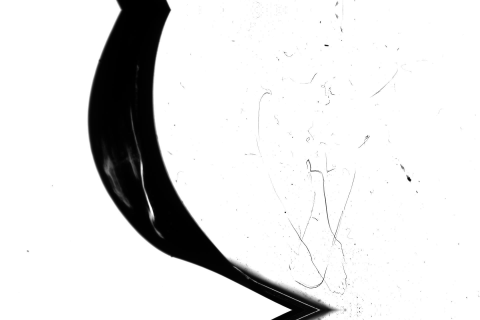

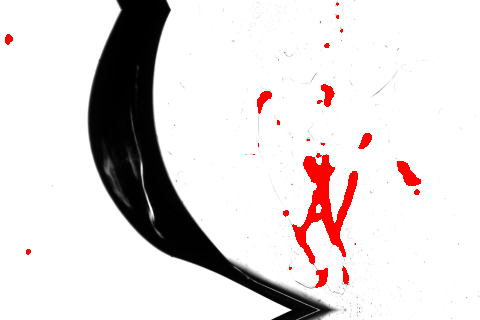

In [12]:
predicted, image_pred_path = get_pred(model, "01.png", ".")

In [13]:
import json

def torch_to_json(tensor):
    return json.dumps(tensor.numpy().tolist())

def json_to_torch(data):
    return torch.tensor(np.array(json.loads(data)))

data = torch_to_json(predicted)
torch.all(json_to_torch(data) == predicted)

tensor(True)

In [14]:
image_pred_path

'./segmented-c7ec50e1-048e-4cc7-9d30-957e340b2ff5.png'

In [15]:
with open("predicted.json", "w") as f:
    f.write(data)